<a href="https://colab.research.google.com/github/geoffcorvera/cnn/blob/colab/catdog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Build model on top of CNN pre-trained on ImageNet dataset. The final classification layer contains a single neuron with output in range [0,1].

In [8]:
import os
import numpy as np 
from tensorflow.keras.applications import InceptionResNetV2
from keras import models
from keras import layers

In [1]:
# Confirm TPU connection
import tensorflow as tf 

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [3]:
# Load resnet pretrained on ImageNet
pre_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))
pre_model.trainable = False

219062272/219055592 [==============================] - 2s 0us/step


In [ ]:
import matplotlib.pyplot as plt

# Visualize inception resnet first layer filters
def getConvLayer(model):
  res = None
  for layer in model.layers:
    if 'conv' in layer.name:
      res = layer
      break
  return res

def visualizeFilters(filters):
  # filters = filters[0]
  nf = filters.shape[3]
  fig, _ = plt.subplots(4,8)
  
  for i, ax in enumerate(fig.axes):
    ax.imshow(filters[:,:,:,i])
    ax.set_axis_off()
  fig.suptitle('1st Convolution Layer Filters')
  plt.show()


conv_layer = getConvLayer(pre_model)
filters = conv_layer.get_weights()
visualizeFilters(conv_layer.get_weights()[0])

In [5]:
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing as preprocessing_layers

print('Building model...\n')

data_augmentation = keras.Sequential(
    [
      preprocessing_layers.RandomFlip('horizontal'),
      preprocessing_layers.RandomRotation(0.1),
      preprocessing_layers.RandomZoom(0.1),
    ]
)

input_shape = (150,150,3)
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)           #Augment data to increase training set
x = preprocessing_layers.Rescaling(1.0/255)(x) #Rescale image values to [0,1]

outputs = pre_model(x)
outputs = layers.Flatten()(outputs)
outputs = layers.Dense(256, activation='relu')(outputs)
outputs = layers.Dense(1, activation='sigmoid')(outputs)

model = keras.Model(inputs, outputs)

model.summary()

Building model...

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 13824)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               3539200   
_________________________________________________________________
dense_1 (Dense)              (None, 1)    

In [100]:
import tensorflow.keras.preprocessing as preprocessing
from google.colab import drive

print('Importing training and test datasets...\n')
batch_size = 64
val_size = batch_size*20

train_path = r'/content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/p3_data/cats_dogs_dataset/dataset/training_set'
all_ds = preprocessing.image_dataset_from_directory(train_path, image_size=(150,150), batch_size=batch_size)
val_ds = all_ds.take(val_size)
train_ds = all_ds.skip(val_size)
# train_ds = train_ds.shuffle(buffer_size=1024).batch(64)

test_path = r'/content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/p3_data/cats_dogs_dataset/dataset/test_set (1)'
test_ds = preprocessing.image_dataset_from_directory(test_path, image_size=(150,150), batch_size=batch_size)


Importing training and test datasets...

Found 8282 files belonging to 2 classes.
Found 2003 files belonging to 2 classes.


# Train
The model is compiled with RMSprop optimizer and binary cross-entropy loss function.

Training continues for 3 epochs, with 0.2% of the training set used for validation to check generalization.

Weights are saved periodically during training to the "training" directory. When model fitting is complete, the model is saved to "last_trained" directory for future use.

In [120]:
checkpoint_path = r'/content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/training'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.compile(optimizer='rmsprop',
              metrics=['binary_accuracy']
              loss='binary_crossentropy')
print('Fitting to data...\n')
history = model.fit(train_ds,
                    epochs=5,
                    steps_per_epoch=1500,
                    callbacks=[cp_callback],
                    validation_data=val_ds)

os.listdir(checkpoint_dir)

save_path = r'/content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/last_trained'
model.save(save_path)

Fitting to data...

Epoch 1/5
1500/1500 [==============================] - 44s 22ms/step - loss: 0.1030

Epoch 00001: saving model to /content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/training
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/last_trained/assets


In [119]:
print('Evaluating against test...\n')
results = model.evaluate(test_ds)

Evaluating against test...

32/32 [==============================] - 12s 242ms/step - loss: 0.0780


In [ ]:
y_true = np.concatenate([y.numpy() for _,y in test_ds])
y_pred = model.predict(test_ds).reshape(-1)

In [115]:
threshold = np.where(y_pred>0.9, 1, 0).astype(int) #threshold at 0.9
assert y_pred.shape == y_true.shape

correct = 0
for i, inst in enumerate(zip(threshold, y_true)):
  if i % 200 == 0:
    print(f"{i} => predicted: {inst[0]}\tactual: {inst[1]}")
  if inst[0] == inst[1]:
    correct += 1

print(f'Accuracy = {correct/len(y_pred)}%')

0 => predicted: 0	actual: 0
200 => predicted: 0	actual: 1
400 => predicted: 0	actual: 0
600 => predicted: 0	actual: 1
800 => predicted: 0	actual: 1
1000 => predicted: 0	actual: 1
1200 => predicted: 0	actual: 1
1400 => predicted: 0	actual: 0
1600 => predicted: 0	actual: 0
1800 => predicted: 1	actual: 1
2000 => predicted: 0	actual: 0
Accuracy = 0.5117324013979031%


[[515 485]
 [493 510]]


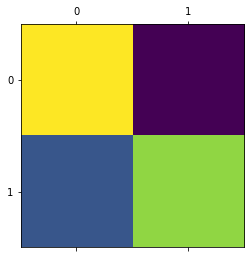

In [117]:
from tensorflow.math import confusion_matrix

con_mat = confusion_matrix(labels=y_true, predictions=threshold).numpy()
print(con_mat)

plt.matshow(con_mat)
plt.show()